In [56]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
matplotlib.rcParams.update({'font.size':13})

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.io import votable
from astropy.utils import data
from astropy.io import fits
from astropy.wcs import WCS
data.conf.remote_timeout = 120 # default is 3 seconds
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore',category=AstropyWarning)
from astroquery.irsa_dust import IrsaDust

In [57]:
###### Variables to change ######
galfa = True # do galfahi sources or named sources
num_off_fields = 10 
search_rad = 3/60 # in degrees
distance=1000*np.linspace(10,1000,500) # default distance array is 10 kpc to 1 Mpc
col=('g','i')
mag='r'
phototype = 'MeanPSFMag'
errortype = 'MeanPSFMagErr'
num_stellar_pops = 1
stages = range(2,9)
#################################

# Stage | Type of star
# ---------------------
# 0      Pre-main sequence
# 1      Main Sequence
# 2      Sub giant branch
# 3      Red giant branch
# 4      Horizontal branch
# 5/6    Blue-ish giants (only present in youngest isochrone)
# 7      Asymptotic giant branch

# isochrone files
old_isochrones = ['t=10Gyr_Fe=-2.0.dat','t=5Gyr_Fe=-2.0.dat',
                  't=10Gyr_Fe=-1.5.dat','t=5Gyr_Fe=-1.5.dat',
                  't=10Gyr_Fe=-1.0.dat','t=5Gyr_Fe=-1.0.dat',]
young_isochrones = ['t=2Gyr_Fe=-2.0.dat','t=500Myr_Fe=-2.0.dat',
                    't=2Gyr_Fe=-1.5.dat','t=500Myr_Fe=-1.5.dat',
                    't=2Gyr_Fe=-1.0.dat','t=500Myr_Fe=-1.0.dat']

old_isocnames = [r'10Gyr, [Fe/H]$=-2.0$',r'5Gyr, [Fe/H]$=-2.0$',
                 r'10Gyr, [Fe/H]$=-1.5$',r'5Gyr, [Fe/H]$=-1.5$',
                 r'10Gyr, [Fe/H]$=-1.0$',r'5Gyr, [Fe/H]$=-1.0$',]
young_isocnames = [r'2Gyr, [Fe/H]$=-2.0$',r'0.5Gyr, [Fe/H]$=-2.0$',
                   r'2Gyr, [Fe/H]$=-1.5$',r'0.5Gyr, [Fe/H]$=-1.5$',
                   r'2Gyr, [Fe/H]$=-1.0$',r'0.5Gyr, [Fe/H]$=-1.0$',] 

# Named sources (for testing)
gals = ['Bootes_dSph','Bootes_II','Canes_Venatici_dSph',
        'Coma_Berenices','Draco_dSph','Hercules_dSph',
        'Leo_IV','Leo_V','Leo_T','Segue_1',
        'Ursa_Major_dSph','Ursa_Major_II','Willman_1_dSph']
gals_ned = ['Bootes+Dwarf','Bootes+II','Canes+Venatici+dSph',
            'Coma+Berenices','Draco+Dwarf','Hercules+Dwarf',
            'Leo+IV','Leo+V','Leo+T','Segue+1',
            'Ursa+Major+Dwarf','Ursa+Major+II','Willman+1']

# HI sources from galfahi
HIsources = Table.read('LeoT_like_sources_176cubes_ynm.csv',
                       format='csv')
HIcandidates = HIsources[HIsources['y/n/m'] == 'y']
HIcoords = SkyCoord(ra=HIcandidates['ra [deg]'],
                    dec=HIcandidates['dec [deg]'],
                    unit=u.deg,frame='icrs')

# Tables for main analysis 
names = gals
names_ned = gals_ned
path = 'plots/CMDs/'
if galfa:
    names = HIcandidates['id']
    names = names.astype(str)
    names_ned = ['']*len(names)
    path = 'plots/candidates/CMDs/'
cname0, cname1, mname = \
col[0]+phototype, col[1]+phototype, mag+phototype
cerr0, cerr1, merr = \
col[0]+errortype, col[1]+errortype, mag+errortype

## Set these manually if you don't want to do all sources in one go ##
#names = ['Leo_T']
#names_ned = ['Leo+T']
#isochrones = ['t=12Gyr_Fe=-1.5.dat','t=500Myr_Fe=-1.5.dat']
#isocnames = [r'12Gyr, [Fe/H]$=-1.5$',r'0.5Gyr, [Fe/H]$=-1.5$']

In [58]:
## Functions to download data and read in files ##

url_templ = 'http://gsss.stsci.edu/webservices/vo/CatalogSearch.aspx?'+\
            'CAT=PS1V3OBJECTS&RA={ra}&DEC={dec}&SR={rad}'
ned_template = 'https://ned.ipac.caltech.edu/cgi-bin/nDistance?name={name}'
img_name_template = 'http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?'+\
                    'ra={ra}&dec={dec}&filters={filters}'
img_download_template = 'http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'+\
                        'format=fits&size={size}&red={name}&ra={ra}&dec={dec}'

def get_votable(ra=0,dec=0,radius=5/60,name=''):
    # ra, dec, radius must be in degrees
    if name != '':
        gal = SkyCoord.from_name(name)
        ra = gal.ra.deg
        dec = gal.dec.deg
    url = url_templ.format(ra=ra,dec=dec,rad=radius)
    tab = votable.parse_single_table(url).to_table()
    return tab

def get_field_coords(ra=0,dec=0,numoff=6,spacing=10/60,name=''):
    # ra, dec, spacing must be in degrees, numoff must be even
    assert numoff % 2 == 0, 'numoff is not even!'
    if name != '':
        source = SkyCoord.from_name(name)
    else:
        source = SkyCoord(ra=ra,dec=dec,unit=u.deg,frame='icrs')
    l, b = source.galactic.l, source.galactic.b
    l_near = np.arange(-numoff/2,numoff/2+1,1)*spacing
    l_near = np.roll(l_near,int(numoff/2+1))
    b_near = np.zeros(l_near.size)    
    l_tab = l + l_near*u.deg
    b_tab = b + b_near*u.deg
    lbs = SkyCoord(l=l_tab,b=b_tab,unit=u.deg,frame='galactic')
    radecs = SkyCoord(ra=lbs.icrs.ra,dec=lbs.icrs.dec,
                      unit=u.deg,frame='icrs')
    return radecs, b
    

def get_image_cutout(ra=0,dec=0,filters='g',size=1440):
    # "size" should be twice the search radius (1440 pixels = 6 arcmin)
    img_name = img_name_template.format(ra=ra,dec=dec,filters=filters)
    img_params = Table.read(data.download_file(img_name),
                            format='ascii')
    img_download = img_download_template.format(size=size,name=img_params['filename'][0],
                                                ra=ra,dec=dec)
    img_fits = data.download_file(img_download)

    return img_fits

def get_extinctions(ra=0,dec=0):
    coord = SkyCoord(ra=ra,dec=dec,unit=u.deg,frame='icrs')
    tab = IrsaDust.get_extinction_table(coord)
    return tab
    
def get_ned_distance(name=''):
    tab = []
    if name != '':
        ned_url = ned_template.format(name=name)
        tab = Table.read(ned_url,format='html')
    return tab

def load_isochrone(name='',stages=range(9)):
    isoc = []
    if name != '':
        isoc = Table.read('isochrones/'+name,format='ascii')
        isoc = Table(isoc,names=('metallicity','logage','M_ini','M_act',
                                 'logL/Lo','logTe','logG','mbol',
                                 'g','r','i','z','y','w','int_IMF','stage'))
        which_stages = (isoc['stage'] < 0)
        for s in stages:
            which_stages += (isoc['stage'] == s)
    return isoc[which_stages]

In [59]:
## Functions to calculate isochrone stage probabilities and fit CMD to one or two isochrones ##

def get_int_IMF_diff(isochrone):
    int_IMF_diff = np.zeros(9)
    for s in range(9):
        stage = np.where(isochrone['stage'] == s)[0]
        if stage.size:
            int_IMF_diff[s] = isochrone['int_IMF'][stage[-1]] -\
                              isochrone['int_IMF'][stage[0]]
    return int_IMF_diff

def fit_isochrone(table,isochrone,distance=distance,
                  col=('g','i'),mag='r',phototype='MeanPSFMag',
                  errortype='MeanPSFMagErr'):
    distmodulus = 5*np.log10(distance/10)
    numclosestars = np.zeros(distance.size)
    magerr = table[mag+errortype]
    colerr = np.sqrt(table[col[0]+errortype]**2+table[col[1]+errortype]**2)
    weights = (np.mean(magerr) + np.mean(colerr))/(magerr+colerr)
    for j in range(distance.size):
        iso = np.array([isochrone[col[0]]-isochrone[col[1]],
                        isochrone[mag]+distmodulus[j]])
        for i in range(table[mag+phototype].size):
            point = np.array([table[col[0]+phototype][i]-table[col[1]+phototype][i],
                              table[mag+phototype][i]]).reshape(-1,1)
            close = np.where( (np.abs(point[1]-iso[1]) < magerr[i])*\
                              (np.abs(point[0]-iso[0]) < colerr[i]) )[0]
            if close.size:
                which_stages = isochrone['stage'][close]
                numclosestars[j] += weights[i]*np.max(get_int_IMF_diff(isochrone)[which_stages])
    return numclosestars

def fit_two_isochrones(table,isochrone1,isochrone2,distance=distance,
                       col=('g','i'),mag='r',phototype='MeanPSFMag',
                       errortype='MeanPSFMagErr'):
    # default distance array is 10 kpc to 1 Mpc
    distmodulus = 5*np.log10(distance/10)
    numclosestars = np.zeros(distance.size)
    magerr = table[mag+errortype]
    colerr = np.sqrt(table[col[0]+errortype]**2+table[col[1]+errortype]**2)
    weights = (np.mean(magerr) + np.mean(colerr))/(magerr+colerr)
    for j in range(distance.size):
        iso1 = np.array([isochrone1[col[0]]-isochrone1[col[1]],
                         isochrone1[mag]+distmodulus[j]])
        iso2 = np.array([isochrone2[col[0]]-isochrone2[col[1]],
                         isochrone2[mag]+distmodulus[j]])
        for i in range(table[mag+phototype].size):
            point = np.array([table[col[0]+phototype][i]-table[col[1]+phototype][i],
                              table[mag+phototype][i]]).reshape(-1,1)
            close1 = np.where( (np.abs(point[1]-iso1[1]) < magerr[i])*\
                               (np.abs(point[0]-iso1[0]) < colerr[i]) )[0]
            close2 = np.where( (np.abs(point[1]-iso2[1]) < magerr[i])*\
                               (np.abs(point[0]-iso2[0]) < colerr[i]) )[0]
            which_stages1 = isochrone1['stage'][close1]
            which_stages2 = isochrone2['stage'][close2]
            most_likely1, most_likely2 = 0, 0
            if which_stages1.size:
                most_likely1 = np.max(get_int_IMF_diff(isochrone1)[which_stages1])
            if which_stages2.size:
                most_likely2 = np.max(get_int_IMF_diff(isochrone2)[which_stages2])
            numclosestars[j] += weights[i]*max(most_likely1,most_likely2)
    return numclosestars

Leo_T ...
0 3
0 5
1 3
1 5
2 5
3 5


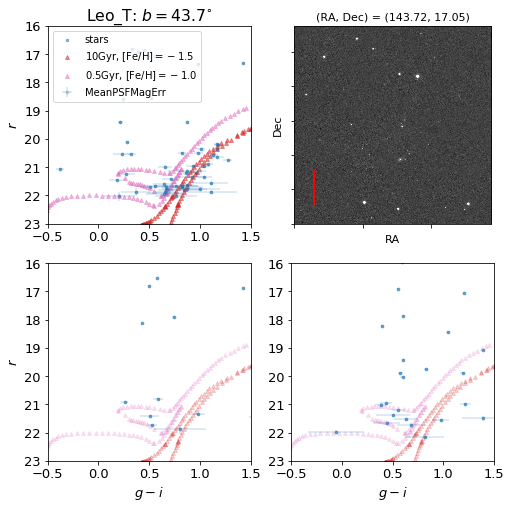

In [62]:
## Do isochrone fit for desired sources ##

for i in range(len(names)):
    print(names[i],'...')
    controls = 0
    # get source coordinates and off-field coordinates
    if galfa:
        coords, gal_lat = get_field_coords(ra=HIcoords[i].ra.deg,dec=HIcoords[i].dec.deg,
                                           numoff=num_off_fields,spacing=10/60)
    else:
        coords, gal_lat = get_field_coords(numoff=num_off_fields,spacing=10/60,name=names[i])

    # get distance to object from NED
    ned_tab = get_ned_distance(name=names_ned[i])
    if ned_tab != []:
        ned_dist = int(ned_tab['Metric Distance(Mpc)'][0] * 1000) # in kpc
    
    # array for best fit function of distance
    closestars = np.zeros((len(coords),distance.size))
    
    imagefits = get_image_cutout(ra=coords[0].ra.deg,dec=coords[0].dec.deg)
    image = fits.open(imagefits)
    wcs = WCS(image[0].header)
    
    f = pl.figure(figsize=(8,8))
    #f, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2,2,sharex='col',sharey='row')
    #f.subplots_adjust(hspace=0)
    ax1 = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    #ax2.axis('off')
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)

    im2 = ax2.imshow(image[0].data,origin='lower',cmap=mpl.cm.gray,
                     interpolation='none',vmax=0.01*np.max(image[0].data))
    ax2.set_xlabel('RA',fontsize=11)
    ax2.set_ylabel('Dec',fontsize=11)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_title('(RA, Dec) = ('+str(np.round(coords[0].ra.deg,2))+', '+str(np.round(coords[0].dec.deg,2))+')',fontsize=11)
    ax2.axvline(x=np.float(coords[0].ra.deg)-2.5/60,ymin=0.1,ymax=0.1+1/6,linewidth=2,color='red')
    #f.colorbar(im2,ax=ax2)
    
    for j in range(len(coords)):
        # get votable for desired coordinate
        tab = get_votable(ra=coords[j].ra.deg,dec=coords[j].dec.deg,radius=search_rad)
    
        # separate stars from non-stars 
        # (see https://confluence.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)
        star_tab = tab[tab['iMeanPSFMag']-tab['iMeanKronMag'] < 0.05]

        # only use stars with defined magnitudes and magstds (!= -999) 
        star_tab = star_tab[(star_tab[mname] != -999)*\
                            (star_tab[cname0] != -999)*(star_tab[cname1] != -999)]
        star_tab = star_tab[(star_tab[merr] != -999)*\
                            (star_tab[cerr0] != -999)*(star_tab[cerr1] != -999)]

        # correct for extinction
        extinct = get_extinctions(ra=coords[j].ra.deg,dec=coords[j].dec.deg)
        star_tab[mname+'0'] = star_tab[mname] -\
                              extinct['A_SandF'][extinct['Filter_name'] == 'SDSS '+mag]
        star_tab[cname0+'0'] = star_tab[cname0] -\
                               extinct['A_SandF'][extinct['Filter_name'] == 'SDSS '+col[0]]            
        star_tab[cname1+'0'] = star_tab[cname1] -\
                               extinct['A_SandF'][extinct['Filter_name'] == 'SDSS '+col[1]] 
        
        if j == 0:
            if num_stellar_pops == 1:
                # perform isochrone fits for a single "old" population
                maxclosestars = np.zeros(len(old_isochrones))
                Nstarlist = []
                for k in range(len(old_isochrones)):
                    isoc = load_isochrone(name=old_isochrones[k],stages=stages)
                    numclosestars = fit_isochrone(star_tab,isoc,
                                                  col=col,mag=mag,
                                                  phototype=phototype+'0',
                                                  errortype=errortype)
                    Nstarlist.append(numclosestars)
                    maxclosestars[k] = np.max(numclosestars)
                bestisoc_ind = np.where(maxclosestars == np.max(maxclosestars))[0][0]
                bestisoc = load_isochrone(name=old_isochrones[bestisoc_ind],
                                          stages=stages)
                # store best fit
                closestars[j] = Nstarlist[bestisoc_ind]
            elif num_stellar_pops == 2: 
                # perform two-isochrone fits for an "old" and "young" population simultaneously
                maxclosestars = np.zeros((len(old_isochrones),len(young_isochrones)))
                Nstarlist = [[] for _ in range(len(old_isochrones))]
                for k in range(len(old_isochrones)-2):
                    for l in range(len(young_isochrones)):
                        if k in [0,2] and l < k+2:
                            Nstarlist[k].append([])
                            continue
                        elif k in [1,3] and l < k+1:
                            Nstarlist[k].append([])
                            continue
                        if l in [2,4,6]:
                            Nstarlist[k].append([])
                            continue
                        print(k,l)
                        isoc1 = load_isochrone(name=old_isochrones[k],stages=stages)
                        isoc2 = load_isochrone(name=young_isochrones[l],stages=stages)#(3,4,5,6))
                        numclosestars = fit_two_isochrones(star_tab,isoc1,isoc2,
                                                           col=col,mag=mag,
                                                           phototype=phototype+'0',
                                                           errortype=errortype)
                        Nstarlist[k].append(numclosestars)
                        maxclosestars[k][l] = np.max(numclosestars)
                bestisoc_ind = np.where(maxclosestars == np.max(maxclosestars))
                bestisoc_old = load_isochrone(name=old_isochrones[bestisoc_ind[0][0]],
                                              stages=stages)
                bestisoc_young = load_isochrone(name=young_isochrones[bestisoc_ind[1][0]],
                                                stages=stages)
                # store best fit
                closestars[j] = Nstarlist[bestisoc_ind[0][0]][bestisoc_ind[1][0]]
            
            # find distance of object based on best fit   
            bestdist = distance[closestars[j]==np.max(closestars[j])][0]

            # Plot CMD with best-fit isochrone(s) 
            #f1 = pl.figure(figsize=(6,6))
            ax1.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                       star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
            ax1.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                        xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                        yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
            ax1.set_xlim(-0.5,1.5)
            #ax1.set_xticks(np.arange(-0.5,2,0.5))
            ax1.set_ylim(16,23)
            ax1.set_yticks(np.arange(16,24))
            #pl.xticks(np.arange(-0.5,2,0.5))
            #pl.ylim(16,23)
            #ax1.set_xlabel(r'$g-i$')
            ax1.set_ylabel(r'$r$')
            ax1.invert_yaxis()
            if num_stellar_pops == 1:
                ax1.scatter(bestisoc[col[0]]-bestisoc[col[1]],
                           bestisoc[mag]+5*np.log10(bestdist/10),
                           s=15,alpha=1,label=old_isocnames[bestisoc_ind],
                           marker='^',color='C'+str(bestisoc_ind+1))
            elif num_stellar_pops == 2:
                ax1.scatter(bestisoc_old[col[0]]-bestisoc_old[col[1]],
                           bestisoc_old[mag]+5*np.log10(bestdist/10),
                           s=15,alpha=0.5,label=old_isocnames[bestisoc_ind[0][0]],
                           marker='^',color='C'+str(bestisoc_ind[0][0]+1))
                ax1.scatter(bestisoc_young[col[0]]-bestisoc_young[col[1]],
                           bestisoc_young[mag]+5*np.log10(bestdist/10),
                           s=15,alpha=0.5,label=young_isocnames[bestisoc_ind[1][0]],
                           marker='^',color='C'+str(bestisoc_ind[1][0]+1))
            ax1.legend(loc='upper left',fontsize=10)
            ax1.set_title(names[i]+r': $b=$'+str(np.round(gal_lat.deg,1))+r'$^{\circ}$')
            #pl.savefig(path+names[i]+'_CMD.pdf')
            #pl.close(f1)

        elif j > 0:    
            # perform isochrone fits on off-fields with bestisoc
            if num_stellar_pops == 1:
                closestars[j] = fit_isochrone(star_tab,bestisoc,
                                              col=col,mag=mag,
                                              phototype=phototype+'0',
                                              errortype=errortype)
            elif num_stellar_pops == 2:
                closestars[j] = fit_two_isochrones(star_tab,bestisoc_old,
                                                   bestisoc_young,col=col,mag=mag,
                                                   phototype=phototype+'0',
                                                   errortype=errortype)
            if j == 1:
                #f1 = pl.figure(figsize=(6,6))
                ax3.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                           star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
                ax3.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                            xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                            yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
                ax3.set_xlim(-0.5,1.5)
                ax3.set_xticks(np.arange(-0.5,2,0.5))
                ax3.set_ylim(16,23)
                ax3.set_yticks(np.arange(16,24))
                #pl.xticks(np.arange(-0.5,2,0.5))
                #pl.ylim(16,23)
                ax3.set_xlabel(r'$g-i$')
                ax3.set_ylabel(r'$r$')
                ax3.invert_yaxis()
                if num_stellar_pops == 1:
                    ax3.scatter(bestisoc[col[0]]-bestisoc[col[1]],
                               bestisoc[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind],
                               marker='^',color='C'+str(bestisoc_ind+1))
                elif num_stellar_pops == 2:
                    ax3.scatter(bestisoc_old[col[0]]-bestisoc_old[col[1]],
                               bestisoc_old[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind[0][0]],
                               marker='^',color='C'+str(bestisoc_ind[0][0]+1))
                    ax3.scatter(bestisoc_young[col[0]]-bestisoc_young[col[1]],
                               bestisoc_young[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=young_isocnames[bestisoc_ind[1][0]],
                               marker='^',color='C'+str(bestisoc_ind[1][0]+1))
                #pl.legend(loc='upper left',fontsize=12)
                #pl.savefig(path+names[i]+'_CMD_control'+str(controls)+'.pdf')
                #pl.close(f1)
                
            if j == 10:
                                #f1 = pl.figure(figsize=(6,6))
                ax4.scatter(star_tab[cname0+'0']-star_tab[cname1+'0'],
                           star_tab[mname+'0'],s=25,alpha=0.5,marker='.',label='stars')
                ax4.errorbar(star_tab[cname0+'0']-star_tab[cname1+'0'],star_tab[mname+'0'],
                            xerr=np.sqrt(star_tab[cerr0]**2+star_tab[cerr1]**2),
                            yerr=star_tab[merr],alpha=0.2,fmt='.',label=errortype)
                ax4.set_xlim(-0.5,1.5)
                ax4.set_xticks(np.arange(-0.5,2,0.5))
                ax4.set_ylim(16,23)
                #ax4.set_yticks(np.arange(16,24))
                #pl.xticks(np.arange(-0.5,2,0.5))
                #pl.ylim(16,23)
                ax4.set_xlabel(r'$g-i$')
                #ax4.set_ylabel(r'$r$')
                ax4.invert_yaxis()
                if num_stellar_pops == 1:
                    ax4.scatter(bestisoc[col[0]]-bestisoc[col[1]],
                               bestisoc[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind],
                               marker='^',color='C'+str(bestisoc_ind+1))
                elif num_stellar_pops == 2:
                    ax4.scatter(bestisoc_old[col[0]]-bestisoc_old[col[1]],
                               bestisoc_old[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=old_isocnames[bestisoc_ind[0][0]],
                               marker='^',color='C'+str(bestisoc_ind[0][0]+1))
                    ax4.scatter(bestisoc_young[col[0]]-bestisoc_young[col[1]],
                               bestisoc_young[mag]+5*np.log10(bestdist/10),
                               s=15,alpha=0.2,label=young_isocnames[bestisoc_ind[1][0]],
                               marker='^',color='C'+str(bestisoc_ind[1][0]+1))
                #pl.legend(loc='upper left',fontsize=12)
                #pl.savefig(path+names[i]+'_CMD_control'+str(controls)+'.pdf')
                #pl.close(f1)
                controls += 1
                
    pl.savefig(path+names[i]+'_CMD.pdf')
    # plot fit results
    f2 = pl.figure()
    pl.plot(distance/1000,closestars[0],label='Source')
    offstd = np.std(closestars[1:],axis=0)
    offmean = np.mean(closestars[1:],axis=0)
    pl.fill_between(distance/1000,offmean-offstd,offmean+offstd,facecolor='C1',
                    alpha=0.5,label=str(num_off_fields)+' off-fields')
    pl.xlabel('Distance [kpc]')
    pl.ylabel('"Quality" of fit')
    pl.axvline(x=bestdist/1000,linestyle='dotted',color='black',
               label=str(np.int(bestdist/1000))+' kpc')
    if ned_tab != []:
        pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    pl.title(names[i])
    pl.legend()
    pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    pl.savefig(path+names[i]+'_fitresult.pdf')
    pl.close(f2)

    # calculate "zscore" as function of distance
    #f3 = pl.figure()
    #pl.plot(distance/1000,(closestars[0]-offmean)/offstd)
    #pl.xlabel('Distance [kpc]')
    #pl.ylabel('"z-score" of fit')
    #pl.axvline(x=bestdist/1000,linestyle='dotted',color='black',
    #           label=str(np.int(bestdist/1000))+' kpc')
    #if ned_tab != []:
    #    pl.axvline(x=ned_dist,linestyle='dotted',color='red',label=str(ned_dist)+' kpc (NED)')
    #pl.title(names[i])
    #pl.legend()
    #pl.gcf().subplots_adjust(left=0.15,bottom=0.15)
    #pl.savefig(path+names[i]+'_zscore_'+errortype+'.pdf')
    #pl.close(f3)

In [ ]:
# it's really difficult to pick out galaxies even with trying many isochrones.
# seems like to do a bunch at once I need to vary search radius, 
# and select sections of isochrones too (otherwise I may fit for the 
# wrong type of stars). 

In [83]:
## Older version of the stuff above, before I put things into functions ##

# define distance moduli
distance = 1000*np.linspace(10,500,100) # 10 to 500 kpc
distmod = 5*np.log10(distance/10)

# Find best-fit isochrone, once using MagStd, once using MagErr
numclosestars = np.zeros(distance.size)
for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distmod[j]])
        if np.any( (np.abs(point[1]-iso[1]) < star_tab['rMeanPSFMagStd'][i])*(np.abs(point[0]-iso[0]) \
                        < np.sqrt(star_tab['gMeanPSFMagStd'][i]**2+star_tab['iMeanPSFMagStd'][i]**2)) ):
            numclosestars[j] += 1
            
numclosestars1 = np.zeros(distance.size)
for j in range(distance.size):
    for i in range(star_tab['rMeanPSFMag'].size):
        point = np.array([star_tab['gMeanPSFMag'][i]-star_tab['iMeanPSFMag'][i],
                          star_tab['rMeanPSFMag'][i]]).reshape(-1,1)
        iso = np.array([isoc15['g']-isoc15['i'],isoc15['r']+distmod[j]])
        if np.any( (np.abs(point[1]-iso[1]) < star_tab['rMeanPSFMagErr'][i])*(np.abs(point[0]-iso[0]) \
                        < np.sqrt(star_tab['gMeanPSFMagErr'][i]**2+star_tab['iMeanPSFMagErr'][i]**2)) ):
            numclosestars1[j] += 1

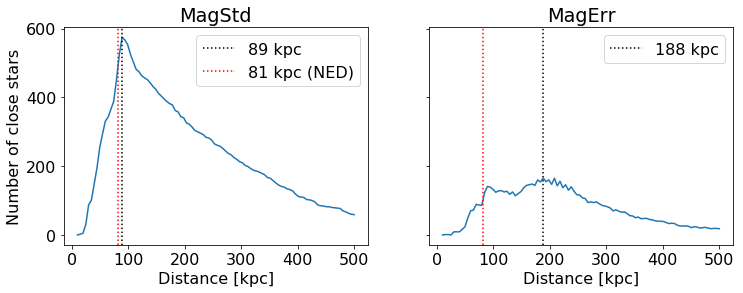

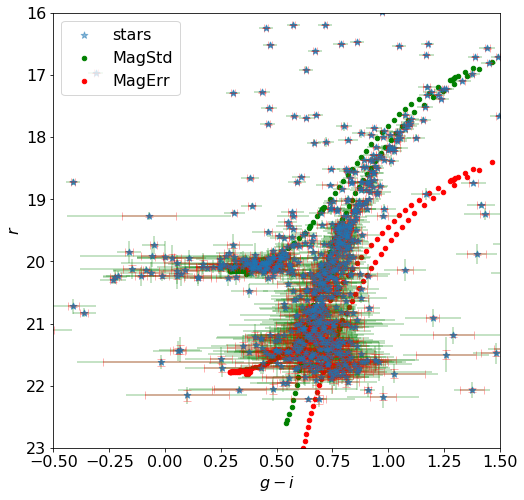

In [84]:
## Detailed plots comparing MagStd and MagErr ##

# Plot results of fit            
f, (ax1, ax2) = pl.subplots(1,2,sharex=True,sharey=True,figsize=(12,4))            
ax1.plot(distance/1000,numclosestars,label='')
ax1.set_xlabel('Distance [kpc]')
ax1.set_ylabel('Number of close stars')
bestdist = distance[numclosestars==numclosestars.max()][0]
ax1.axvline(x=bestdist/1000,linestyle='dotted',color='black',label=str(np.int(bestdist/1000))+' kpc')
ax1.axvline(x=81,linestyle='dotted',color='red',label='81 kpc (NED)')
ax1.set_title('MagStd')
ax1.legend()
ax2.plot(distance/1000,numclosestars1,label='')
ax2.set_xlabel('Distance [kpc]')
bestdist1 = distance[numclosestars1==numclosestars1.max()][0]
ax2.axvline(x=bestdist1/1000,linestyle='dotted',color='black',label=str(np.int(bestdist1/1000))+' kpc')
ax2.axvline(x=81,linestyle='dotted',color='red',label='')
ax2.set_title('MagErr')
ax2.legend()

# Galaxy CMD with best-fit isochrones
f = pl.figure(figsize=(8,8))
pl.scatter(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
           s=50,alpha=0.5,marker='*',label='stars')
pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
            xerr=np.sqrt(star_tab['gMeanPSFMagStd']**2+star_tab['iMeanPSFMagStd'][i]**2),
            yerr=star_tab['rMeanPSFMagStd'],alpha=0.3,fmt='*',ecolor='green',label='')
pl.errorbar(star_tab['gMeanPSFMag']-star_tab['iMeanPSFMag'],star_tab['rMeanPSFMag'],
            xerr=np.sqrt(star_tab['gMeanPSFMagErr']**2+star_tab['iMeanPSFMagErr'][i]**2),
            yerr=star_tab['rMeanPSFMagErr'],alpha=0.3,fmt='*',ecolor='red',capsize=4,label='')
pl.xlim(-0.5,1.5)
pl.ylim(16,23)
pl.xlabel(r'$g-i$')
pl.ylabel(r'$r$')
pl.gca().invert_yaxis()
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist/10),
           s=20,alpha=1,label='MagStd',marker='o',color='green')
pl.scatter(isoc15['g']-isoc15['i'],isoc15['r']+5*np.log10(bestdist1/10),
           s=20,alpha=1,label='MagErr',marker='o',color='red')
pl.legend(loc='upper left')